# K Means Clustering

Implement a clustering algorithms and different clustering quality measurements.
For each dataset calculate dependence of chosen clustering quality measurements on number of clusters.
Plot clustering result and real class distribution. Perform PCA projection for non two dimensional datasets before visualization but after clustering.

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import OrderedDict

from os.path import join

## Doing PCA to reduce dimension and pick the most useful eigen values

In [15]:
class Utils:
    @staticmethod
    def do_pca(matrix):
        mean = np.mean(matrix.T, axis=1)
        centroid_matrix = matrix - mean
        covariance_matrix = np.cov(centroid_matrix.T)
        eigen_values, eigen_vector = np.linalg.eig(covariance_matrix)
        eigen_pairs = [(np.abs(eigen_values[i]), eigen_vector[:,i]) for i in range(len(eigen_values))]
        eigen_pairs.sort(key=lambda x: x[0], reverse=True)
        new_matrix = np.hstack((eigen_pairs[0][1].reshape(len(matrix.T),1), 
                      eigen_pairs[1][1].reshape(len(matrix.T),1)))
        return  matrix.dot(new_matrix)
    
    @staticmethod
    def plot_data(X, Y):
        plt.scatter(X[:,0],X[:,1],s=10, c='black',label='unclustered data')        
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.legend(['Unclustered Data Point'])
        plt.title('Plot of Unclustered Data')
        plt.show()
        
    @staticmethod
    def comput_accuracy(Y, Y_predict):
        correct = 0
        for i in range(len(Y)):
            if Y[i] == Y_predict[i]:
                correct += 1
        
        return correct/len(Y)*100.0
        

In [68]:
class DataProcessor:
    def __init__(self, data_filename, normalize=True):
        self.data_filename = data_filename
        self.__process_data__()
        self.normalize = normalize
        if self.normalize == True:
            self.__normalize__()
        self.X = np.array(self.X)
        self.Y = np.array(self.Y)
        if len(self.X.T) > 2:
            self.X = Utils.do_pca(self.X)
        self.Y = self.__form_labels__(self.Y)
    
    def __normalize__(self):
        normalizer = lambda x: x - x.mean()/x.std()
        self.X = self.X.apply(normalizer, axis=0)
        
    def __form_labels__(self, data):
        current_number = 0
        y_train_dictionary = {}
        new_y_train = []
        for label in data:
            if label in y_train_dictionary:
                new_y_train.append(y_train_dictionary[label])
            else:
                y_train_dictionary[label] = current_number
                new_y_train.append(y_train_dictionary[label])
                current_number += 1
        return np.array(new_y_train)
        
        
    
    def __process_data__(self):
        self.data = pd.read_csv(self.data_filename)
        self.data = self.data.dropna(how='any', axis=1)
        self.__remove_with_one_value__()
        self.X = self.data.iloc[:, :-1]
        self.Y = self.data.iloc[:, -1]
    
    def __remove_with_one_value__(self):
        for col in self.data.columns:
            if len(self.data[col].unique()) == 1:
                self.data.drop(col,inplace=True,axis=1)

    

In [69]:
filename = 'ecoli.csv'
folder_name = 'Task10_DataSet'
filename = join(folder_name, filename)

In [70]:
data = DataProcessor(filename)

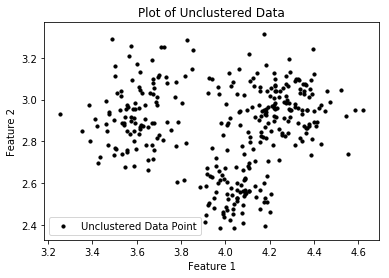

In [71]:
Utils.plot_data(data.X, data.Y)

In [73]:
data.X.shape, data.Y.shape

((336, 2), (336,))

K- Means Clustering

In [100]:
class KMeans:
    def __init__(self, k=3, tolerance=0.0001, max_iterations=500, distance='euclidean'):
        self.tolerance = tolerance
        self.max_iterations = max_iterations
        self.distance = distance
        self.X = np.array([])
        self.Y = np.array([])
        self.centroids = []
        self.k = k
        if self.distance == 'euclidean':
            self.distance_function = self.euclidean_distance
        elif self.distance == 'manhattan':
            self.distance_function = self.manhattan_distance
    
    
    def euclidean_distance(self, point_1, point_2 ):
        squared_distance = 0
        for i in range(len(point_1)):
            squared_distance += np.power( point_1[i] - point_2[i], 2)
        distance = np.sqrt(squared_distance)
        return distance
    
  
    def manhattan_distance(self, point_1, point_2):
        distance = 0
        for i in range(len(point_1)):
            distance += np.abs(point_1[i] - point_2[i])
        return distance
    
     
    def initial_centroids(self):
        for i in range(self.k):
            self.centroids[i] = self.X[i]
    
      
    def __initialize_data__(self,X,Y):
        self.X = X
        self.Y = Y
        self.features = len(X.T)
        self.m = len(X)
        self.centroids = {}
    
    
    def fit(self, X, Y):
        self.__initialize_data__(X,Y)
        self.initial_centroids()
        optimal = False
        
        for i in range(self.max_iterations):
            self.classes = {}
            for i in range(self.k):
                self.classes[i] = []
            
            for point in self.X:      
                distances = [ self.distance_function(point, self.centroids[class_]) for class_ in self.centroids ]
                classification = distances.index(min(distances))
                self.classes[classification].append(point)

            previous_centroids = dict(self.centroids)

            # Averaging and recalcuating the centroids we get
            for class_ in self.classes:
                self.centroids[class_] = np.average(self.classes[class_], axis= 0)


            # Check for tolerance
            for centroid in self.centroids:
                original_centroid = previous_centroids[centroid]
                curr = self.centroids[centroid]
                if np.sum((curr - original_centroid)/original_centroid * 100.0) <  self.tolerance:
                    optimal = True
                    break
    
    
    
    def david_bouldien_index(self):
        cluster_k = [self.classes[k] for k in self.classes]
        variances = [np.mean([self.euclidean_distance(p, self.centroids[i]) for p in self.classes[k]]) for i, k in enumerate(self.classes)]
        db = []
        for i in range(self.k):
            for j in range(self.k):
                if j != i:
                    db.append((variances[i] + variances[j]) / self.euclidean_distance(self.centroids[i], self.centroids[j]))

        return(np.max(db) / self.k)
    
    
    
    
    def mean_centroid_distance(self):
        mean = 0 
        first_center = self.centroids[0]
        for i in range(1, len(self.centroids)): 
            mean += np.mean((first_center - self.centroids[i])**2 )
        return mean/len(self.centroids)
    
    
    
    def predict(self, data):
        classifications = []
        for point in data:
            distances = [ self.distance_function(point, self.centroids[class_]) for class_ in self.centroids ]
            classification = distances.index(min(distances))
            classifications.append(classification)
            
        return np.array(classifications)
    
    def plot_cluster(self, plot_number):
        data_markers = ['+', '_', '*', 's', 'P', '1', '2' , '3', '4', '8']
        centroid_marker = 'x'
        centroid_color = 'red'
        plt.subplot(3,3,plot_number)
        for class_ in self.centroids:
            plt.scatter(self.centroids[class_][0], self.centroids[class_][1], s=100, marker=centroid_marker, color=centroid_color)
        
        for class_ in self.classes:
            marker = data_markers[class_]
            for data in self.classes[class_]:
                title = 'K: {}'.format(self.k)
                plt.title(title)
                plt.scatter(data[0], data[1], s=10, marker=marker, color='C{}'.format(class_))

    def show_plot(self):
        plt.show()

### For Ecoli Data

K Processed: 2345678910

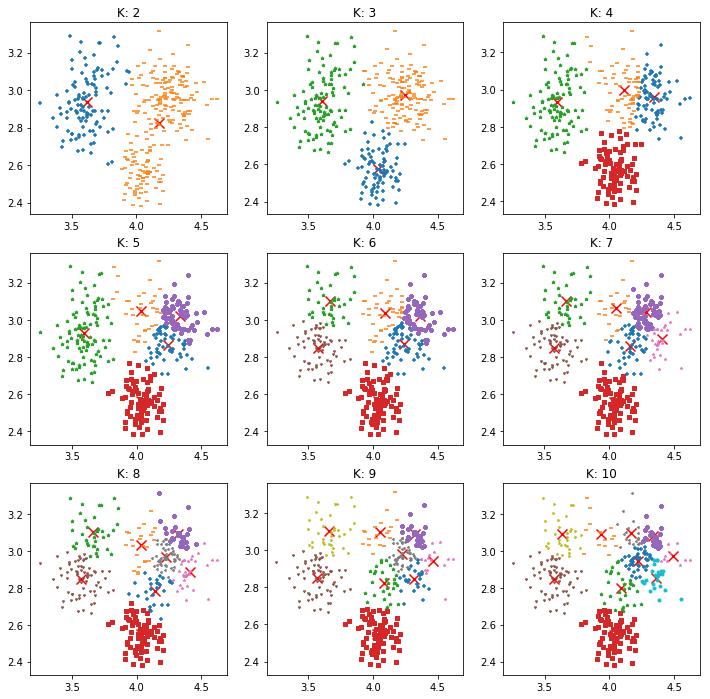

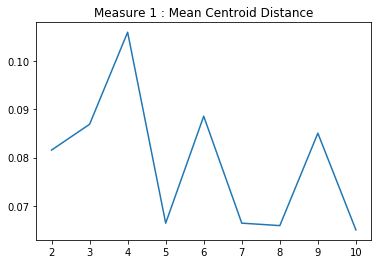

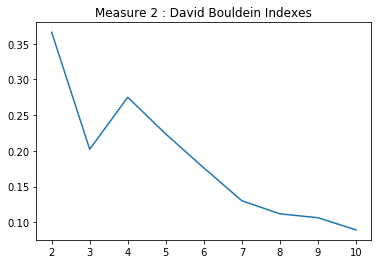

In [115]:
mean_centroid_distance = []
david_bouldien_indexes = []
print('K Processed: ', end='')
plt.figure(figsize=(12,12))
for k in range(2, 11):
    print(k, end='')
    km = KMeans(k)
    km.fit(data.X, data.Y)
    km.plot_cluster(k-1)
    mean_centroid_distance.append(km.mean_centroid_distance())
    david_bouldien_indexes.append(km.david_bouldien_index())
km.show_plot()


plt.title('Measure 1 : Mean Centroid Distance')
x_axis = np.linspace(2,10,9)
plt.plot(x_axis,mean_centroid_distance)
plt.show()

plt.title('Measure 2 : David Bouldein Indexes')
x_axis = np.linspace(2,10,9)
plt.plot(x_axis, david_bouldien_indexes)
plt.show()

In [123]:
print('Original Classes : {}'.format(len(np.unique(data.Y))))

Original Classes : 8
